In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import models,layers

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [4]:
from zipfile import ZipFile
file_name = "/content/PlantVillage.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 0 1 1 0 1 0 1 0 0 1 2 0 1 0 0 0 0 1 0 1 1 1 1 0 0 1 0 1 0 0 1]


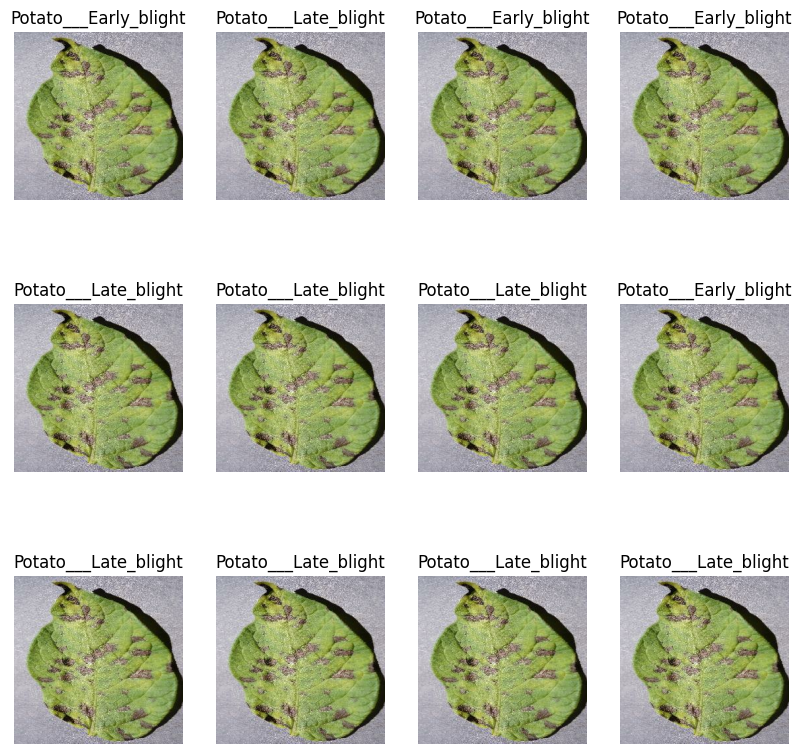

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [10]:
dataset.take(10) #first 10 sample
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds  = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6) #validation dataset
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [16]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed =12)
    train_size = int(train_split* ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

In [21]:
tarin_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [22]:
risize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [24]:
#CNN
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    risize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])
model.build(input_shape = input_shape)


In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [26]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [27]:
history =  model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds

)

Epoch 1/50
54/54 [==============================] - 17s 136ms/step - loss: 0.9185 - accuracy: 0.4783 - val_loss: 0.8844 - val_accuracy: 0.4677
Epoch 2/50
54/54 [==============================] - 7s 77ms/step - loss: 0.7364 - accuracy: 0.6614 - val_loss: 0.9012 - val_accuracy: 0.6438
Epoch 3/50
54/54 [==============================] - 6s 81ms/step - loss: 0.5752 - accuracy: 0.7576 - val_loss: 0.4349 - val_accuracy: 0.8187
Epoch 4/50
54/54 [==============================] - 6s 77ms/step - loss: 0.3533 - accuracy: 0.8495 - val_loss: 0.3262 - val_accuracy: 0.8703
Epoch 5/50
54/54 [==============================] - 7s 78ms/step - loss: 0.3133 - accuracy: 0.8860 - val_loss: 0.2921 - val_accuracy: 0.8662
Epoch 6/50
54/54 [==============================] - 6s 79ms/step - loss: 0.3126 - accuracy: 0.8686 - val_loss: 0.2188 - val_accuracy: 0.9149
Epoch 7/50
54/54 [==============================] - 6s 76ms/step - loss: 0.2311 - accuracy: 0.9055 - val_loss: 0.3427 - val_accuracy: 0.8545
Epoch 8/50


In [28]:
scores = model.evaluate(test_ds)

54/54 [==============================] - 3s 25ms/step - loss: 0.0592 - accuracy: 0.9771


In [29]:
scores

[0.05919748544692993, 0.9771126508712769]

In [30]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [33]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [34]:
history.history['val_accuracy']

[0.46772301197052,
 0.6437793374061584,
 0.8186619877815247,
 0.8703051805496216,
 0.8661971688270569,
 0.9149060845375061,
 0.8544601202011108,
 0.8896713852882385,
 0.9043427109718323,
 0.8632628917694092,
 0.9008215665817261,
 0.9330986142158508,
 0.952464759349823,
 0.9542253613471985,
 0.8550469279289246,
 0.9495305418968201,
 0.8937793374061584,
 0.8403756022453308,
 0.8544601202011108,
 0.9530516266822815,
 0.8767605423927307,
 0.9254694581031799,
 0.9366196990013123,
 0.9460093975067139,
 0.9642018675804138,
 0.9366196990013123,
 0.9765258431434631,
 0.8685445785522461,
 0.9190140962600708,
 0.9460093975067139,
 0.9759389758110046,
 0.9818075299263,
 0.9735915660858154,
 0.9829812049865723,
 0.9917840361595154,
 0.9724178314208984,
 0.9266431927680969,
 0.9600939154624939,
 0.9823943376541138,
 0.9360328912734985,
 0.9782863855361938,
 0.922535240650177,
 0.9759389758110046,
 0.934272289276123,
 0.98591548204422,
 0.9806337952613831,
 0.9753521084785461,
 0.9911971688270569,
 0

In [35]:
len(history.history['val_accuracy'])

50

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

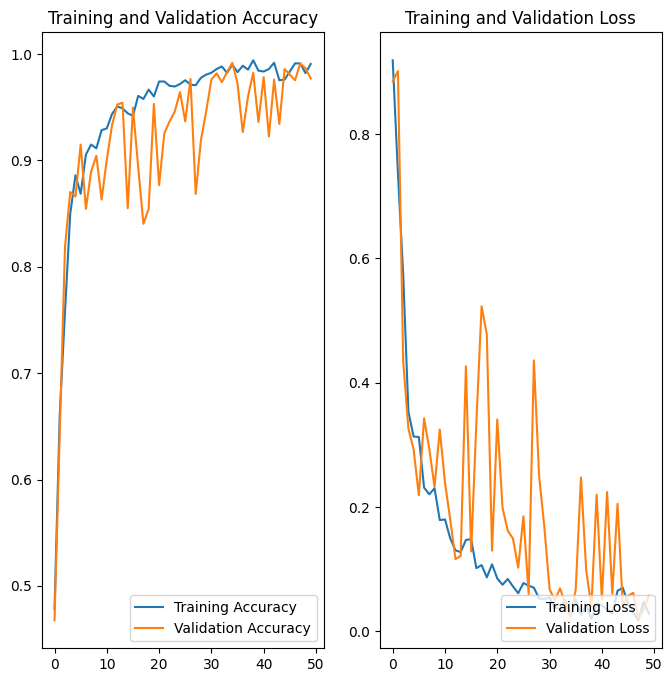

In [41]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc , label = "Training Accuracy")
plt.plot(range(EPOCHS), val_acc , label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss , label = "Training Loss")
plt.plot(range(EPOCHS), val_loss , label = "Validation Loss")
plt.legend(loc = 'lower right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
first image's actual label: Potato___Late_blight
1/1 [==============================] - 0s 58ms/step
[5.5654518e-06 9.9998844e-01 6.0187558e-06]
Predicted_label: Potato___Late_blight


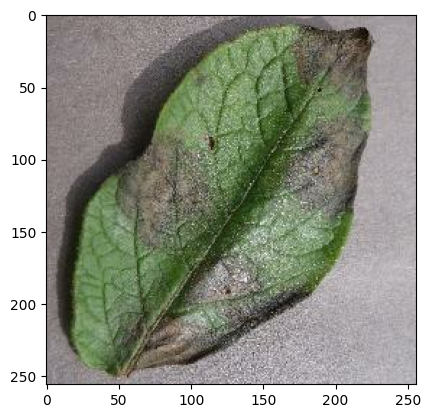

In [56]:
for image_batch, labels_batch in test_ds.take(1):
  first_image = image_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0]
  print("first image to predict")
  plt.imshow(first_image)
  print("first image's actual label:",class_names[first_label])

  batch_prediction = model.predict(image_batch)
  print(batch_prediction[0])
  print("Predicted_label:",class_names[np.argmax(batch_prediction[0])])

In [49]:
np.argmax([9.9999905e-01 ,9.8931798e-07, 9.6477791e-20])

0

In [67]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)
  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])),2)
  return predicted_class, confidence

1/1 [==============================] - 0s 34ms/step


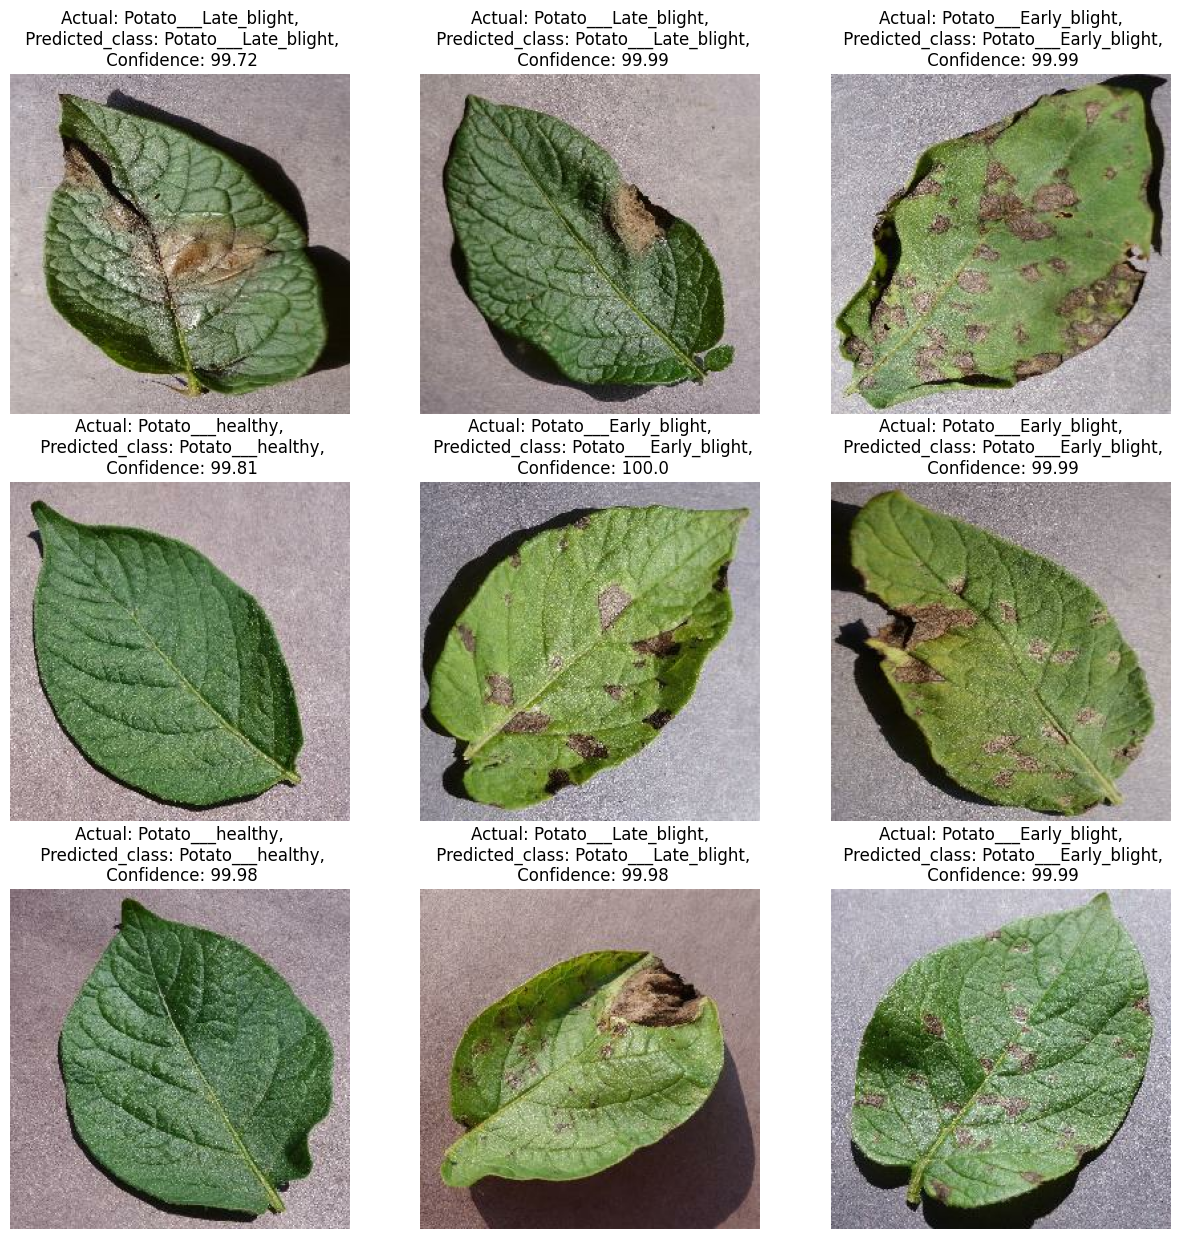

In [69]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    predicted_class,confidence = predict(model,images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class},\n Predicted_class: {predicted_class},\n Confidence: {confidence}" )
    plt.axis("off")
